In [1]:
import pymongo
from pymongo import MongoClient
from google.cloud import bigquery
from bson import ObjectId
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from sklearn import preprocessing
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Посмотрим как распределены пользователи по дням активности и количеству закрашенных картинок

In [301]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
select platform, device_type, b.customer_user_id, activity_days, finished_pics
from (
    select customer_user_id, count(distinct event_date) as activity_days
    from `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch`
    group by customer_user_id) as a
right join (
    select customer_user_id, platform, device_type, count(distinct picture_id) as finished_pics
    from `goingtoclouds.aggregated_data.picture_finish`
    group by customer_user_id, platform, device_type
) as b
on a.customer_user_id=b.customer_user_id
'''

activity_finish_dt = client.query(sql, project=project_id).to_dataframe()

In [302]:
activity_finish_dt = activity_finish_dt[activity_finish_dt.customer_user_id!=0]

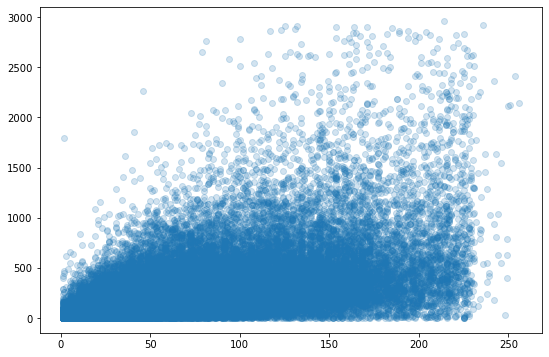

In [303]:
plt.scatter(activity_finish_dt['activity_days'], activity_finish_dt['finished_pics'], alpha=0.2)
# plt.scatter(tb.createTimestamp, tb.bm_added, alpha=0.2)

In [ ]:
plt.scatter(activity_finish_dt['activity_days'], activity_finish_dt['finished_pics'], alpha=0.2)

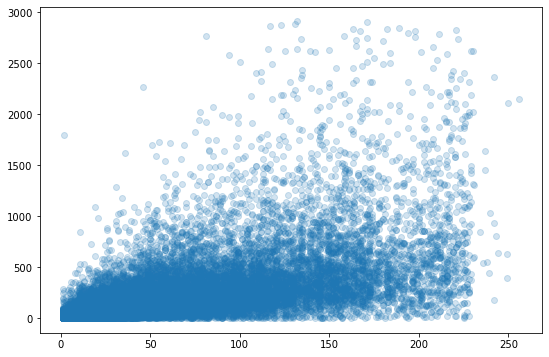

In [305]:
plt.scatter(activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'ios')].activity_days, 
            activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'ios')].finished_pics, alpha=0.2)

In [306]:
plt.scatter(activity_finish_dt[(activity_finish_dt.device_type == 'mobile') & 
                               (activity_finish_dt.platform == 'ios')].activity_days, 
            activity_finish_dt[(activity_finish_dt.device_type == 'mobile') & 
                               (activity_finish_dt.platform == 'ios')].finished_pics, alpha=0.2)

In [307]:
plt.scatter(activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'android')].activity_days, 
            activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'android')].finished_pics, alpha=0.2)

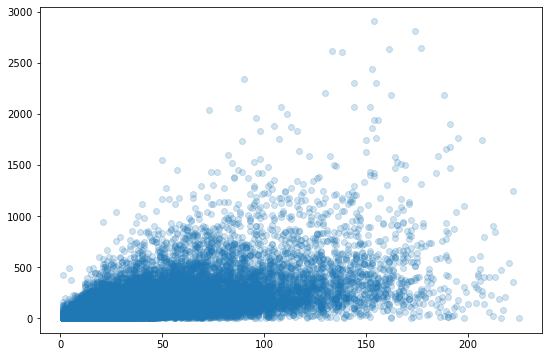

In [308]:
plt.scatter(activity_finish_dt[(activity_finish_dt.device_type == 'mobile') & 
                               (activity_finish_dt.platform == 'android')].activity_days, 
            activity_finish_dt[(activity_finish_dt.device_type == 'mobile') & 
                               (activity_finish_dt.platform == 'android')].finished_pics, alpha=0.2)

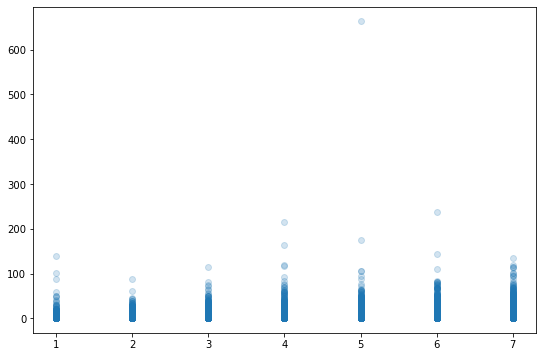

In [314]:
plt.scatter(activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'android') &
                              (activity_finish_dt.activity_days <= 7)].activity_days, 
            activity_finish_dt[(activity_finish_dt.device_type == 'tablet') & 
                               (activity_finish_dt.platform == 'android') &
                              (activity_finish_dt.activity_days <= 7)].finished_pics, alpha=0.2)

### Считаем picture finish за все время жизни

In [137]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
SELECT platform, device_type, customer_user_id, install_day, count(distinct picture_id) as finished_pictures
FROM `goingtoclouds.aggregated_data.picture_finish` 
where country != 'Belarus'
group by platform, device_type, customer_user_id, install_day
'''
pic_finish_dt = client.query(sql, project=project_id).to_dataframe()


In [147]:
finished_pics_per_user = pic_finish_dt[pic_finish_dt.customer_user_id!=0].groupby(["platform", "device_type", 
                                                                                   'customer_user_id']).finished_pictures.sum().reset_index()

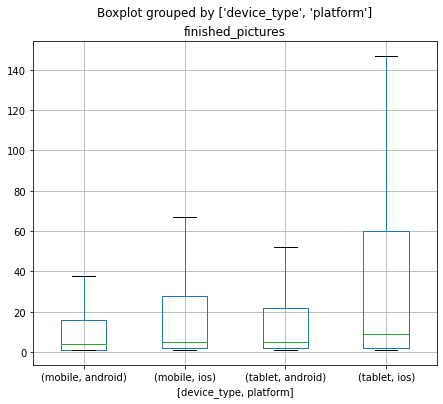

In [148]:
# plt.hist([[pic_finish_dt[(pic_finish_dt.device_type=='mobile') &
#                         (pic_finish_dt.platform=='android')].finished_pictures, 
#            pic_finish_dt[(pic_finish_dt.device_type=='mobile') &
#                          (pic_finish_dt.platform=='ios')].finished_pictures]],
#         bins='auto', rwidth=0.9, align="left")

finished_pics_per_user[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [149]:
finished_pics_per_user.groupby(['device_type', 'platform']).finished_pictures.describe()

count       mean         std  min  25%  50%   75%  \
device_type platform                                                         
mobile      android   166724.0  28.713329   89.197680  1.0  1.0  4.0  16.0   
            ios       127309.0  53.019292  158.212042  1.0  2.0  5.0  28.0   
tablet      android    36113.0  37.317448  109.685257  1.0  2.0  5.0  22.0   
            ios        69973.0  83.155031  211.047205  1.0  2.0  9.0  60.0   

                         max  
device_type platform          
mobile      android   2897.0  
            ios       2945.0  
tablet      android   2791.0  
            ios       2899.0

In [150]:
finished_pics_per_user.groupby(['device_type', 'platform']).customer_user_id.nunique().reset_index()

device_type platform  customer_user_id
0      mobile  android            166724
1      mobile      ios            127309
2      tablet  android             36113
3      tablet      ios             69973

### Cчитаем picture start за все время жизни

In [151]:
sql = '''
SELECT platform, device_type, customer_user_id, install_day, count(distinct picture_id) as started_pictures
FROM `goingtoclouds.aggregated_data.picture_start` 
where country != 'Belarus'
group by platform, device_type, customer_user_id, install_day
'''
pic_start_dt = client.query(sql, project=project_id).to_dataframe()

In [152]:
started_pics_per_user = pic_start_dt[pic_start_dt.customer_user_id!=0].groupby(["platform", "device_type", 
                                                                                'customer_user_id']).started_pictures.sum().reset_index()

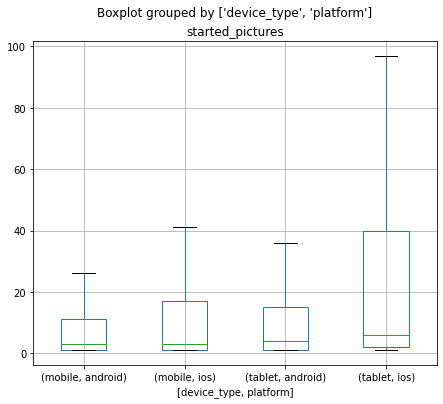

In [153]:
started_pics_per_user[["platform", "device_type", "started_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [154]:
started_pics_per_user.groupby(['device_type', 'platform']).started_pictures.describe()

count       mean         std  min  25%  50%   75%  \
device_type platform                                                         
mobile      android   249885.0  22.830750   79.017114  1.0  1.0  3.0  11.0   
            ios       183513.0  41.555519  140.635176  1.0  1.0  3.0  17.0   
tablet      android    50517.0  30.493101   98.613415  1.0  1.0  4.0  15.0   
            ios        91435.0  70.717384  197.033006  1.0  2.0  6.0  40.0   

                         max  
device_type platform          
mobile      android   2898.0  
            ios       2949.0  
tablet      android   2801.0  
            ios       2906.0

### Считаем количество закрашенных картинок в зависимости от дня жизни 

In [155]:
sql = '''
SELECT platform, device_type, customer_user_id, date_diff(max(event_date), min(install_day), day) as life_days, count(distinct picture_id) as finished_pictures
FROM `goingtoclouds.aggregated_data.picture_finish` 
where country != 'Belarus'
group by platform, device_type, customer_user_id
'''
pic_finish_day_dt = client.query(sql, project=project_id).to_dataframe()

In [162]:
pic_finish_day = pic_finish_day_dt[pic_finish_day_dt.customer_user_id != 0]

d1 = pic_finish_day[pic_finish_day.life_days >= 1].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d3 = pic_finish_day[pic_finish_day.life_days >= 3].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d7 = pic_finish_day[pic_finish_day.life_days >= 7].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d30 = pic_finish_day[pic_finish_day.life_days >= 30].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d90 = pic_finish_day[pic_finish_day.life_days >= 90].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d180 = pic_finish_day[pic_finish_day.life_days >= 180].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()

In [203]:
# print(d1.describe())
# print(d3.describe())
# print(d7.describe())
# print(d30.describe())
# print(d90.describe())
# print(d180.describe())

d1['user_type'] = 1
d3['user_type'] = 3
d7['user_type'] = 7
d30['user_type'] = 30
d90['user_type'] = 90
d180['user_type'] = 180

dd = pd.concat([d1, d3, d7, d30, d90, d180])

In [204]:
finish_lifetime = dd.groupby(["device_type", "platform", "user_type"]).agg({'finished_pictures' : ['mean', 'median']}).reset_index()

In [205]:
finish_lifetime.columns = ['device_type', 'platform', 'user_type', 'mean', 'median']

In [206]:
finish_lifetime['device'] = finish_lifetime['device_type']+ ' ' + finish_lifetime['platform']

In [207]:
finish_lifetime

device_type platform  user_type        mean  median          device
0       mobile  android          1   45.354531      10  mobile android
1       mobile  android          3   50.953280      12  mobile android
2       mobile  android          7   57.943950      15  mobile android
3       mobile  android         30   79.401868      23  mobile android
4       mobile  android         90  107.351217      33  mobile android
5       mobile  android        180  131.641737      52  mobile android
6       mobile      ios          1   76.127789      14      mobile ios
7       mobile      ios          3   83.709417      17      mobile ios
8       mobile      ios          7   93.084260      21      mobile ios
9       mobile      ios         30  122.278315      34      mobile ios
10      mobile      ios         90  170.683485      58      mobile ios
11      mobile      ios        180  232.076514      99      mobile ios
12      tablet  android          1   54.982531      12  tablet android
13      tablet  android          3   59.960289      14  tablet android
14      tablet  android          7   66.512994      17  tablet android
15      tablet  android         30   88.725436      27  tablet android
16      tablet  android         90  123.590975      43  tablet android
17      tablet  android        180  150.276762      65  tablet android
18      tablet      ios          1  107.323778      20      tablet ios
19      tablet      ios          3  113.566250      24      tablet ios
20      tablet      ios          7  121.131993      28      tablet ios
21      tablet      ios         30  146.410533      43      tablet ios
22      tablet      ios         90  196.935919      73      tablet ios
23      tablet      ios        180  241.398404     101      tablet ios

In [208]:
mean_finish = pd.pivot(finish_lifetime, index='device', columns='user_type', values='mean').reset_index()


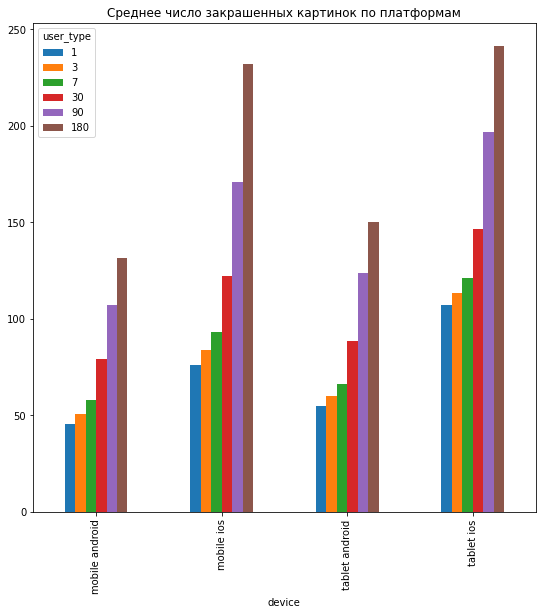

In [233]:
mean_finish.plot(x='device', 
        kind='bar', 
        stacked=False, 
        title='Среднее число закрашенных картинок по платформам') 
plt.rcParams["figure.figsize"] = (9, 6)

In [228]:
median_finish = pd.pivot(finish_lifetime, index='device', columns='user_type', values='median').reset_index()

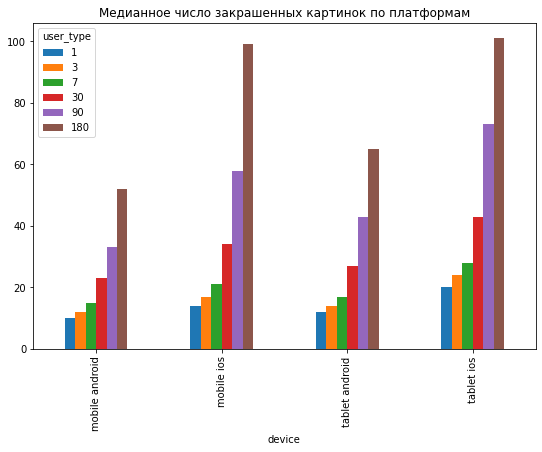

In [235]:
median_finish.plot(x='device', 
        kind='bar', 
        stacked=False, 
        title='Медианное число закрашенных картинок по платформам') 
plt.rcParams["figure.figsize"] = (9, 6)

In [236]:
median_finish

user_type          device   1   3   7  30  90  180
0          mobile android  10  12  15  23  33   52
1              mobile ios  14  17  21  34  58   99
2          tablet android  12  14  17  27  43   65
3              tablet ios  20  24  28  43  73  101

### Считаем количество начатых картинок в зависимости от дня жизни

In [237]:
sql = '''
SELECT platform, device_type, customer_user_id, date_diff(max(event_date), min(install_day), day) as life_days, count(distinct picture_id) as finished_pictures
FROM `goingtoclouds.aggregated_data.picture_start` 
where country != 'Belarus'
group by platform, device_type, customer_user_id
'''
pic_start_day_dt = client.query(sql, project=project_id).to_dataframe()

In [257]:
pic_start_day = pic_start_day_dt[(pic_start_day_dt.customer_user_id != 0)]

d1 = pic_start_day[pic_start_day.life_days >= 1].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d3 = pic_start_day[pic_start_day.life_days >= 3].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d7 = pic_start_day[pic_start_day.life_days >= 7].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d30 = pic_start_day[pic_start_day.life_days >= 30].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d90 = pic_start_day[pic_start_day.life_days >= 90].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()
d180 = pic_start_day[pic_start_day.life_days >= 180].groupby(['device_type', 'platform', 
                                                      'customer_user_id']).finished_pictures.sum().reset_index()

In [258]:
d1['user_type'] = 1
d3['user_type'] = 3
d7['user_type'] = 7
d30['user_type'] = 30
d90['user_type'] = 90
d180['user_type'] = 180

dd = pd.concat([d1, d3, d7, d30, d90, d180])
start_lifetime = dd.groupby(["device_type", "platform", "user_type"]).agg({'finished_pictures' : ['mean', 'median']}).reset_index()
start_lifetime.columns = ['device_type', 'platform', 'user_type', 'mean', 'median']
start_lifetime['device'] = start_lifetime['device_type']+ ' ' + start_lifetime['platform']

In [259]:
start_lifetime

device_type platform  user_type        mean  median          device
0       mobile  android          1   37.195734       8  mobile android
1       mobile  android          3   44.872999      11  mobile android
2       mobile  android          7   52.037634      13  mobile android
3       mobile  android         30   72.711989      19  mobile android
4       mobile  android         90   99.416911      28  mobile android
5       mobile  android        180  126.267044      46  mobile android
6       mobile      ios          1   63.116260       9      mobile ios
7       mobile      ios          3   73.528594      13      mobile ios
8       mobile      ios          7   83.318528      16      mobile ios
9       mobile      ios         30  111.723198      27      mobile ios
10      mobile      ios         90  158.260522      46      mobile ios
11      mobile      ios        180  220.121823      86      mobile ios
12      tablet  android          1   46.391312       9  tablet android
13      tablet  android          3   53.797533      12  tablet android
14      tablet  android          7   60.547090      14  tablet android
15      tablet  android         30   81.883610      22  tablet android
16      tablet  android         90  116.022123      37  tablet android
17      tablet  android        180  145.883442      56  tablet android
18      tablet      ios          1   94.984778      14      tablet ios
19      tablet      ios          3  104.808108      19      tablet ios
20      tablet      ios          7  113.484655      23      tablet ios
21      tablet      ios         30  139.787728      36      tablet ios
22      tablet      ios         90  192.609574      67      tablet ios
23      tablet      ios        180  241.089410      98      tablet ios

In [260]:
median_start = pd.pivot(start_lifetime, index='device', columns='user_type', values='median').reset_index()

median_start.plot(x='device', 
        kind='bar', 
        stacked=False, 
        title='Медианное число начатых картинок по платформам') 
plt.rcParams["figure.figsize"] = (9, 6)

In [261]:
median_start

user_type          device   1   3   7  30  90  180
0          mobile android   8  11  13  19  28   46
1              mobile ios   9  13  16  27  46   86
2          tablet android   9  12  14  22  37   56
3              tablet ios  14  19  23  36  67   98

In [78]:
d1[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')
# plt.boxplot(d1.finished_pictures, sym='')


In [86]:
d1[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                         \
                                 count       mean         std  min  25%   50%   
device_type platform                                                            
mobile      android           114944.0  37.621999  102.307612  1.0  2.0   6.0   
            ios                96556.0  66.325324  175.850268  1.0  2.0   9.0   
tablet      android            26130.0  47.190432  122.955491  1.0  2.0   8.0   
            ios                57078.0  97.626739  226.080869  1.0  3.0  15.0   

                                    
                       75%     max  
device_type platform                
mobile      android   26.0  2864.0  
            ios       45.0  2915.0  
tablet      android   35.0  2761.0  
            ios       82.0  3575.0

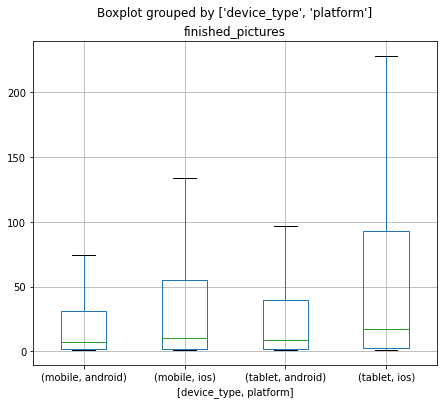

In [79]:
d3[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [87]:
d3[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                    \
                                 count        mean         std  min  25%   
device_type platform                                                       
mobile      android            92179.0   42.395198  109.646793  1.0  2.0   
            ios                81695.0   73.975849  186.406716  1.0  2.0   
tablet      android            22100.0   51.539638  129.290069  1.0  2.0   
            ios                51430.0  104.284523  233.206822  1.0  3.0   

                                          
                       50%   75%     max  
device_type platform                      
mobile      android    7.0  31.0  2784.0  
            ios       10.0  55.0  2915.0  
tablet      android    9.0  40.0  2761.0  
            ios       17.0  93.0  3575.0

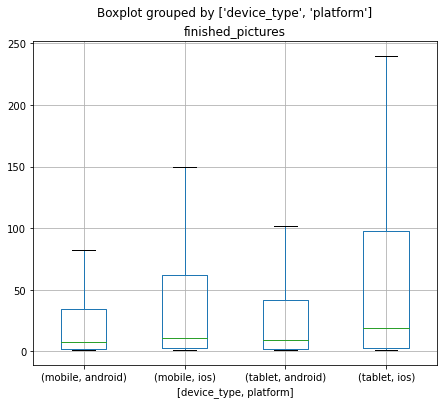

In [80]:
d7[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [88]:
d7[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                    \
                                 count        mean         std  min  25%   
device_type platform                                                       
mobile      android            76594.0   44.862757  113.270655  1.0  2.0   
            ios                71027.0   79.112788  193.008404  1.0  3.0   
tablet      android            19213.0   53.439754  131.652455  1.0  2.0   
            ios                47402.0  107.310810  235.751495  1.0  3.0   

                                          
                       50%   75%     max  
device_type platform                      
mobile      android    8.0  34.0  2701.0  
            ios       11.0  62.0  2904.0  
tablet      android    9.0  42.0  2761.0  
            ios       19.0  98.0  3575.0

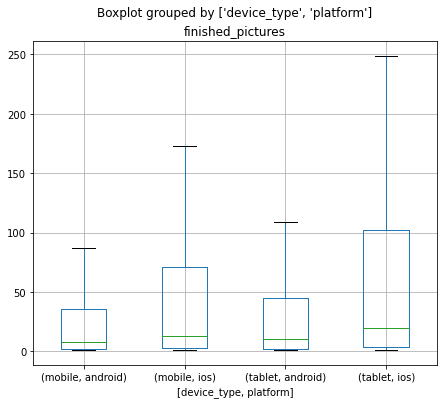

In [81]:
d30[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [89]:
d30[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                    \
                                 count        mean         std  min  25%   
device_type platform                                                       
mobile      android            46080.0   44.883529  109.168817  1.0  2.0   
            ios                49509.0   83.754873  194.280040  1.0  3.0   
tablet      android            12484.0   52.960109  125.031121  1.0  2.0   
            ios                37226.0  106.360098  226.653124  1.0  4.0   

                                           
                       50%    75%     max  
device_type platform                       
mobile      android    8.0   36.0  2452.0  
            ios       13.0   71.0  2884.0  
tablet      android   10.0   45.0  2565.0  
            ios       20.0  102.0  3575.0

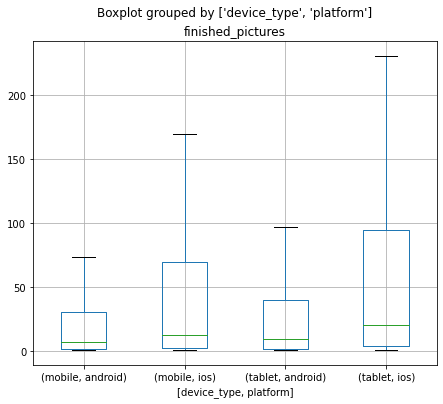

In [82]:
d90[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [90]:
d90[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                         \
                                 count       mean         std  min  25%   50%   
device_type platform                                                            
mobile      android            19189.0  35.150138   81.823961  1.0  2.0   7.0   
            ios                28126.0  74.628209  164.061709  1.0  3.0  13.0   
tablet      android             5399.0  41.096499   86.865108  1.0  2.0  10.0   
            ios                23201.0  91.409638  182.901404  1.0  4.0  21.0   

                                    
                       75%     max  
device_type platform                
mobile      android   31.0  1601.0  
            ios       70.0  2289.0  
tablet      android   40.0  1828.0  
            ios       95.0  2449.0

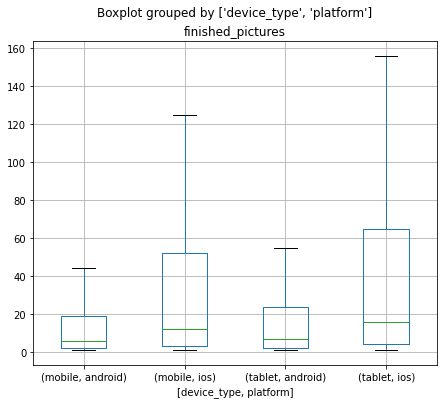

In [83]:
d180[["platform", "device_type", "finished_pictures"]].boxplot(by=['device_type', 'platform'], sym='')

In [91]:
d180[["platform", "device_type", "finished_pictures"]].groupby(['device_type', 'platform']).describe()

finished_pictures                                         \
                                 count       mean         std  min  25%   50%   
device_type platform                                                            
mobile      android             2322.0  19.265289   41.173693  1.0  2.0   6.0   
            ios                11306.0  53.035556  110.682129  1.0  3.0  12.0   
tablet      android              711.0  21.395218   41.545799  1.0  2.0   7.0   
            ios                 9751.0  62.157112  119.054533  1.0  4.0  16.0   

                                    
                       75%     max  
device_type platform                
mobile      android   19.0   595.0  
            ios       52.0  1747.0  
tablet      android   23.5   602.0  
            ios       65.0  1288.0

In [264]:
sql = '''
select  platform, device_type, customer_user_id,life_day, count(distinct picture_id) as finished_pics 
from  (
    select platform, device_type, customer_user_id, date_diff(event_date, min_install_day, day) as life_day, picture_id   
    from (
        SELECT platform, device_type, customer_user_id, event_date,
        min(install_day) over (partition by customer_user_id) as min_install_day, picture_id
        FROM `goingtoclouds.aggregated_data.picture_finish` 
        where country != 'Belarus')
)
group by platform, device_type, customer_user_id, life_day
'''
pic_finish_day = client.query(sql, project=project_id).to_dataframe()


AttributeError: 'DataFrameGroupBy' object has no attribute 'finished_pictures'

In [270]:
visit_day = pic_finish_day[(pic_finish_day.life_day>=0) & 
                          (pic_finish_day.life_day<=200)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pics.median().reset_index()
visit_day

device_type platform  life_day  finished_pics
0        mobile  android       0.0            2.0
1        mobile  android       1.0            2.0
2        mobile  android       2.0            2.0
3        mobile  android       3.0            2.0
4        mobile  android       4.0            2.0
..          ...      ...       ...            ...
799      tablet      ios     196.0            2.0
800      tablet      ios     197.0            2.0
801      tablet      ios     198.0            2.0
802      tablet      ios     199.0            2.0
803      tablet      ios     200.0            2.0

[804 rows x 4 columns]

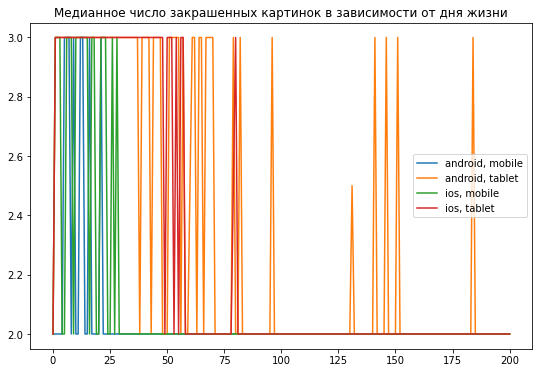

In [276]:
visit_day = pic_finish_day[(pic_finish_day.life_day>=0) & 
                          (pic_finish_day.life_day<=200)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pics.median().reset_index()
pl = ['android', 'ios']
t = ['mobile', 'tablet']
fig, ax = plt.subplots()

for i in pl:
    for j in t:        
        dat = visit_day[(visit_day['platform']==i) & (visit_day['device_type']==j)]
        dates =  dat['life_day']
        y = dat['finished_pics']
        ax.plot(dates, y, label = "{}, {}".format(i, j))

ax.legend()
plt.title('Медианное число закрашенных картинок в зависимости от дня жизни')
plt.show()        

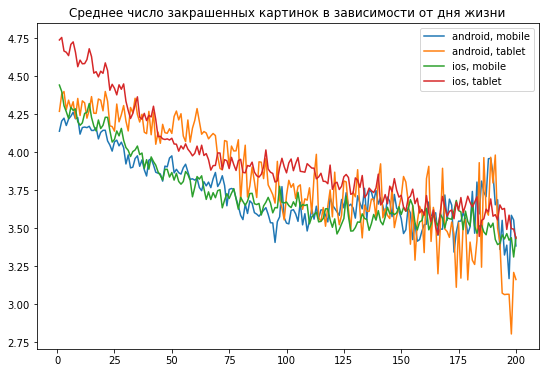

In [277]:
visit_day = pic_finish_day[(pic_finish_day.life_day>0) & 
                           (pic_finish_day.life_day<=200)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pics.mean().reset_index()

pl = ['android', 'ios']
t = ['mobile', 'tablet']
fig, ax = plt.subplots()

for i in pl:
    for j in t:        
        dat = visit_day[(visit_day['platform']==i) & (visit_day['device_type']==j)]
        dates =  dat['life_day']
        y = dat['finished_pics']
        ax.plot(dates, y, label = "{}, {}".format(i, j))

ax.legend()
plt.title('Среднее число закрашенных картинок в зависимости от дня жизни')
plt.show() 

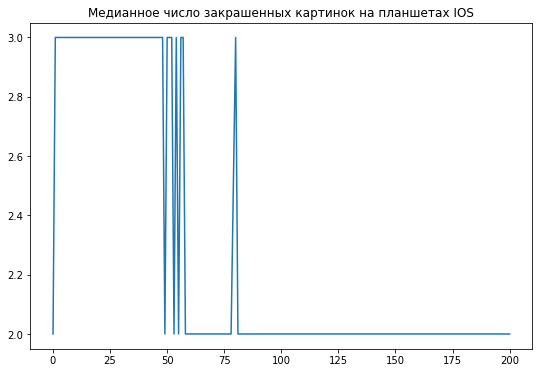

In [286]:
visit_day = pic_finish_day[(pic_finish_day.life_day>=0) & 
                          (pic_finish_day.life_day<=200)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pics.median().reset_index()

fig, ax = plt.subplots()

dat = visit_day[(visit_day['platform']=='ios') & (visit_day['device_type']=='tablet')]
dates =  dat['life_day']
y = dat['finished_pics']
plt.title('Медианное число закрашенных картинок на планшетах IOS')
ax.plot(dates, y, label = "Template: {}, {}".format(i, j))

Text(0.5, 1.0, 'Медианное число закрашенных картинок на планшетах Android')

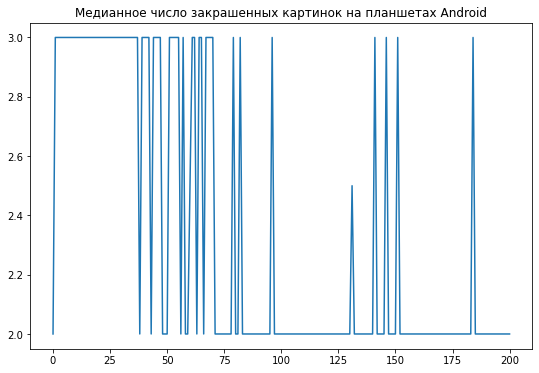

In [287]:
fig, ax = plt.subplots()

dat = visit_day[(visit_day['platform']=='android') & (visit_day['device_type']=='tablet')]
dates =  dat['life_day']
y = dat['finished_pics']
ax.plot(dates, y, label = "Template: {}, {}".format(i, j))
plt.title('Медианное число закрашенных картинок на планшетах Android')

Text(0.5, 1.0, 'Медианное число закрашенных картинок на смартфонах IOS')

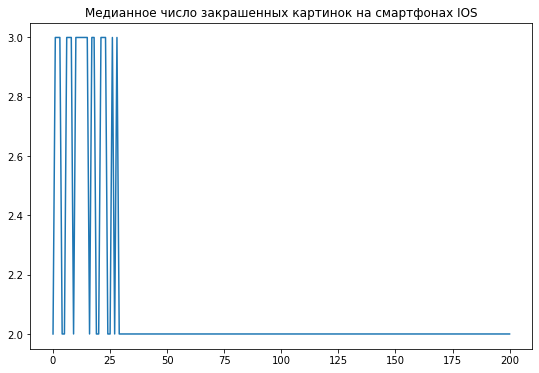

In [288]:
fig, ax = plt.subplots()

dat = visit_day[(visit_day['platform']=='ios') & (visit_day['device_type']=='mobile')]
dates =  dat['life_day']
y = dat['finished_pics']
ax.plot(dates, y, label = "Template: {}, {}".format(i, j))
plt.title('Медианное число закрашенных картинок на смартфонах IOS')

Text(0.5, 1.0, 'Медианное число закрашенных картинок на смартфонах Android')

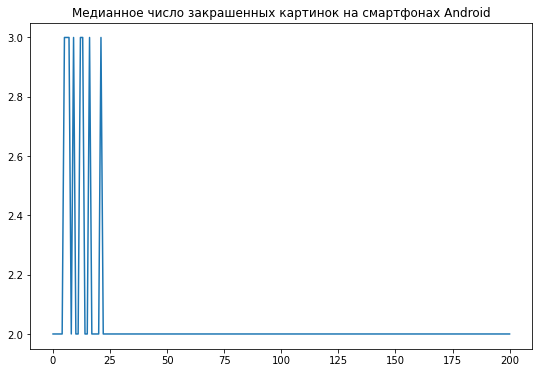

In [289]:
fig, ax = plt.subplots()

dat = visit_day[(visit_day['platform']=='android') & (visit_day['device_type']=='mobile')]
dates =  dat['life_day']
y = dat['finished_pics']
ax.plot(dates, y, label = "Template: {}, {}".format(i, j))
plt.title('Медианное число закрашенных картинок на смартфонах Android')

In [117]:
sql = '''
SELECT platform, device_type, customer_user_id, install_day, event_date, count(distinct picture_id) as finished_pictures
FROM `goingtoclouds.aggregated_data.picture_start` 
where country != 'Belarus'
group by platform, device_type, customer_user_id, install_day, event_date
'''
pic_start_day_dt = client.query(sql, project=project_id).to_dataframe()
pic_start_day_dt['life_day'] = (pic_start_day_dt['event_date'] - pic_start_day_dt['install_day']).dt.days

In [132]:
pic_start_day = pic_start_day_dt[(pic_start_day_dt.customer_user_id!=0) & (pic_start_day_dt.life_day>=0)]
visit_day = pic_start_day[(pic_start_day.life_day>=0)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pictures.median().reset_index()

In [133]:
pic_start_day[(pic_start_day.life_day>=0)].groupby(['device_type', 'platform']).finished_pictures.describe()

count      mean       std  min  25%  50%  75%    max
device_type platform                                                          
mobile      android   1574900.0  3.620859  4.576967  1.0  1.0  2.0  4.0  895.0
            ios       2114585.0  3.606252  4.284131  1.0  1.0  2.0  4.0  324.0
tablet      android    399706.0  3.846652  4.441712  1.0  1.0  2.0  5.0  221.0
            ios       1640640.0  3.940733  4.475872  1.0  1.0  2.0  5.0  290.0

In [134]:
pic_finish_day[(pic_finish_day.life_day>=0)].groupby(['device_type', 'platform']).finished_pictures.describe()

count      mean       std  min  25%  50%  75%    max
device_type platform                                                          
mobile      android   1212800.0  3.827815  4.303841  1.0  1.0  2.0  5.0  113.0
            ios       1745013.0  3.808750  4.253626  1.0  1.0  2.0  5.0  114.0
tablet      android    326607.0  3.993341  4.340672  1.0  1.0  2.0  5.0   81.0
            ios       1423310.0  4.010604  4.391501  1.0  1.0  2.0  5.0  108.0

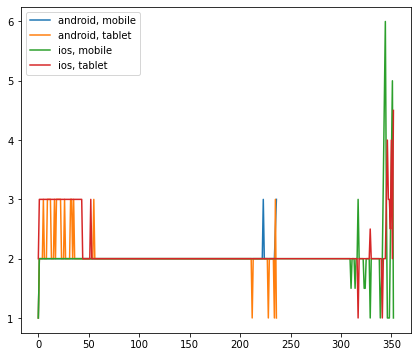

In [130]:
pl = ['android', 'ios']
t = ['mobile', 'tablet']
fig, ax = plt.subplots()

for i in pl:
    for j in t:        
        dat = visit_day[(visit_day['platform']==i) & (visit_day['device_type']==j)]
        dates =  dat['life_day']
        y = dat['finished_pictures']
        ax.plot(dates, y, label = "{}, {}".format(i, j))

ax.legend()
plt.show() 

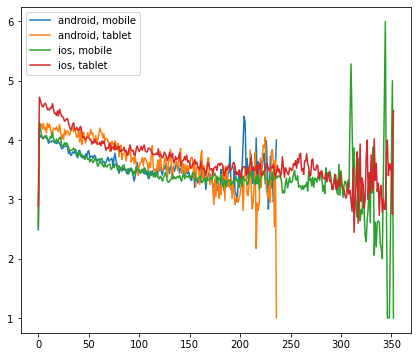

In [131]:
visit_day = pic_start_day[(pic_start_day.life_day>=0)].groupby(['device_type', 'platform', 
                                                                 'life_day']).finished_pictures.mean().reset_index()

pl = ['android', 'ios']
t = ['mobile', 'tablet']
fig, ax = plt.subplots()

for i in pl:
    for j in t:        
        dat = visit_day[(visit_day['platform']==i) & (visit_day['device_type']==j)]
        dates =  dat['life_day']
        y = dat['finished_pictures']
        ax.plot(dates, y, label = "{}, {}".format(i, j))

ax.legend()
plt.show() 

In [291]:
3768465/207672

18.146235409684504